In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from collections import OrderedDict
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn import mixture


# Load the prepared training set

In [2]:
train = pd.read_csv("train.csv", header=0)
test = pd.read_csv("test.csv", header=0)
validate = pd.read_csv("validate.csv", header=0)

### Arrange the data sets

In [24]:
X_train = train.drop(['Vote'],1)
Y_train = train.Vote
# X_train = test.drop(['Vote'],1)
# Y_train = test.Vote
# X_train = validate.drop(['Vote'],1)
# Y_train = validate.Vote

Please see the comment regarding the test data sets in the en

# Train at least one generative model and one clustering model

My mission is to find the most stable\strong coalision. That is, find p parties that will represnt at least 51% of the votes, and will have the following properties: relatively homogeneous with respect to the
participating parties, and very much different from the opposition.

### First step - clustering using KMeans and GMM for data exploration

Since I need p parties with more than 51% of the vote, I will start with k=2. (I will later find that Weighted_education_rank is a very siginificant feature and will uncomment the line in order to check it)

After trying both GMM and Kmeans, investigating the results of the Kmeans seemed to make more sense to me, since the sizes of the cluster and the semantics were more reasonable to me.

In [4]:
# X_train = X_train.drop(['Weighted_education_rank'],1)
# X_train['Weighted_education_rank'] = X_train['Weighted_education_rank']+ X_train['Weighted_education_rank_isNull']
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)
gmm = mixture.GaussianMixture(n_components=2, covariance_type='tied').fit(X_train)


In [5]:
gmm_labels = gmm.predict(X_train)

In [6]:
kmeans.labels_

array([0, 0, 0, ..., 0, 1, 1], dtype=int32)

Calculate the size of every party in each cluster:

In [7]:
cluster_a = {'Purples':0, 'Browns':0, 'Greens':0, 'Blues':0, 'Whites':0, 'Pinks':0, 'Reds':0,
       'Oranges':0, 'Yellows':0, 'Greys':0}
cluster_b = {'Purples':0, 'Browns':0, 'Greens':0, 'Blues':0, 'Whites':0, 'Pinks':0, 'Reds':0,
       'Oranges':0, 'Yellows':0, 'Greys':0}
total_votes = {'Purples':0, 'Browns':0, 'Greens':0, 'Blues':0, 'Whites':0, 'Pinks':0, 'Reds':0,
       'Oranges':0, 'Yellows':0, 'Greys':0}
parties = Y_train.unique()

In [8]:
for i in range(len(Y_train)):
    for party in parties:
        if Y_train[i]==party:
            total_votes[party] = total_votes[party]+1
            if kmeans.labels_[i]==1:
#             if gmm_labels[i]==1:
                cluster_a[party]= cluster_a[party]+1
            else:
                cluster_b[party]= cluster_b[party]+1
                

Plot the 2 clusters:

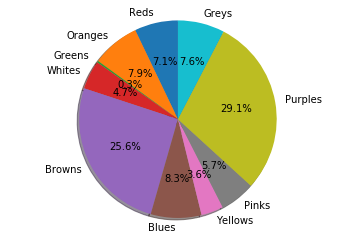

In [9]:
labels_a = cluster_a.keys()
sizes_a = cluster_a.values()

fig1, ax1 = plt.subplots()
ax1.pie(sizes_a, explode=[0]*len(sizes_a), labels=labels_a, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

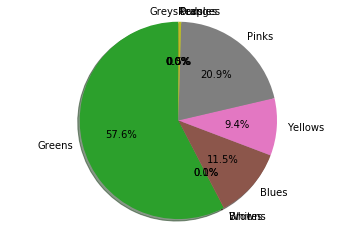

In [10]:
labels_b = cluster_b.keys()
sizes_b = cluster_b.values()

fig1, ax1 = plt.subplots()
ax1.pie(sizes_b, explode=[0]*len(sizes_b), labels=labels_b, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [11]:
od_a = OrderedDict(sorted(cluster_a.items(), key=lambda x:x[1], reverse=True))
od_a

OrderedDict([('Purples', 1241),
             ('Browns', 1091),
             ('Blues', 353),
             ('Oranges', 335),
             ('Greys', 325),
             ('Reds', 303),
             ('Pinks', 244),
             ('Whites', 200),
             ('Yellows', 155),
             ('Greens', 11)])

In [12]:
od_b = OrderedDict(sorted(cluster_b.items(), key=lambda x:x[1], reverse=True))
od_b

OrderedDict([('Greens', 1004),
             ('Pinks', 364),
             ('Blues', 201),
             ('Yellows', 164),
             ('Purples', 8),
             ('Whites', 1),
             ('Reds', 0),
             ('Oranges', 0),
             ('Browns', 0),
             ('Greys', 0)])

In [13]:
total_a = sum(cluster_a.values())
total_a

4258

In [14]:
total_b = sum(cluster_b.values())
total_b

1742

In [15]:
total_b - total_a

-2516

In [16]:
total_votes_ordered = OrderedDict(sorted(total_votes.items(), key=lambda x:x[1], reverse=True))
total_votes_ordered

OrderedDict([('Purples', 1249),
             ('Browns', 1091),
             ('Greens', 1015),
             ('Pinks', 608),
             ('Blues', 554),
             ('Oranges', 335),
             ('Greys', 325),
             ('Yellows', 319),
             ('Reds', 303),
             ('Whites', 201)])

An optional coalition could include: Purples, Browns, Greys, Reds, Oranges

In [17]:
total = sum(total_votes.values())
(total_votes['Purples'] + total_votes['Browns'] + total_votes['Greys']+ total_votes['Reds']+ total_votes['Oranges'])*100/total

55

It seems that it's a close call, With only 380 votes in favor of the Greens' coalition.
Also, it seems like the Browns are equaly likely to end up in both coalitions.
However, when examening the total results, the Purples seem more likely to succeed in building the coalition.

### Second step - Identify the leading features for each party

In [18]:
X_train.dtypes

Number_of_valued_Kneset_members                         float64
Yearly_IncomeK                                          float64
Overall_happiness_score                                 float64
Avg_Satisfaction_with_previous_vote                     float64
Garden_sqr_meter_per_person_in_residancy_area           float64
Weighted_education_rank                                 float64
Number_of_valued_Kneset_members_isNull                    int64
Yearly_IncomeK_isNull                                     int64
Overall_happiness_score_isNull                            int64
Avg_Satisfaction_with_previous_vote_isNull                int64
Garden_sqr_meter_per_person_in_residancy_area_isNull      int64
Weighted_education_rank_isNull                            int64
Most_Important_Issue_int                                  int64
Will_vote_only_large_party_int                            int64
dtype: object

In [19]:
features_means = {'Number_of_valued_Kneset_members':0, 'Yearly_IncomeK':0, 'Overall_happiness_score':0, 'Avg_Satisfaction_with_previous_vote':0, 'Garden_sqr_meter_per_person_in_residancy_area':0, 'Weighted_education_rank':0, 'Most_Important_Issue_int':0}

I now need to calculate the what features are unique for each party. That is, statisticaly speaking, what features are relatively extreme.

### Third Step - Identify the factor most likely to change the winner

In [20]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, kmeans.labels_)
regr.feature_importances_

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

It seems that Weighted_education_rank is the factoer we are looking for, so I will now run again the model without the education factor.

### Last step - Identify a group of factors for strengthening the coalition

I will now explore the features importences for each class:

In [21]:
Y_train.unique()

array(['Greens', 'Blues', 'Browns', 'Purples', 'Reds', 'Oranges', 'Greys',
       'Pinks', 'Whites', 'Yellows'], dtype=object)

In [22]:
X_train.dtypes.keys()

Index([u'Number_of_valued_Kneset_members', u'Yearly_IncomeK',
       u'Overall_happiness_score', u'Avg_Satisfaction_with_previous_vote',
       u'Garden_sqr_meter_per_person_in_residancy_area',
       u'Weighted_education_rank', u'Number_of_valued_Kneset_members_isNull',
       u'Yearly_IncomeK_isNull', u'Overall_happiness_score_isNull',
       u'Avg_Satisfaction_with_previous_vote_isNull',
       u'Garden_sqr_meter_per_person_in_residancy_area_isNull',
       u'Weighted_education_rank_isNull', u'Most_Important_Issue_int',
       u'Will_vote_only_large_party_int'],
      dtype='object')

In [23]:
for party in Y_train.unique():
    regr = RandomForestRegressor(max_depth=2, random_state=0)
    regr.fit(X_train, Y_train==party)
    print(str(party)+': \n'+str([str(X_train.dtypes.keys()[i])+': '+ str(regr.feature_importances_[i]) for i in range(len(regr.feature_importances_))]))
    print('\n')

Greens: 
['Number_of_valued_Kneset_members: 0.0', 'Yearly_IncomeK: 0.0', 'Overall_happiness_score: 0.77146478271', 'Avg_Satisfaction_with_previous_vote: 0.0', 'Garden_sqr_meter_per_person_in_residancy_area: 0.0', 'Weighted_education_rank: 0.0', 'Number_of_valued_Kneset_members_isNull: 0.0', 'Yearly_IncomeK_isNull: 0.0', 'Overall_happiness_score_isNull: 0.0', 'Avg_Satisfaction_with_previous_vote_isNull: 0.0', 'Garden_sqr_meter_per_person_in_residancy_area_isNull: 0.0', 'Weighted_education_rank_isNull: 0.0', 'Most_Important_Issue_int: 0.0', 'Will_vote_only_large_party_int: 0.22853521729']


Blues: 
['Number_of_valued_Kneset_members: 0.0', 'Yearly_IncomeK: 0.00436011878575', 'Overall_happiness_score: 0.014205302712', 'Avg_Satisfaction_with_previous_vote: 0.958613287809', 'Garden_sqr_meter_per_person_in_residancy_area: 0.0', 'Weighted_education_rank: 0.0228212906936', 'Number_of_valued_Kneset_members_isNull: 0.0', 'Yearly_IncomeK_isNull: 0.0', 'Overall_happiness_score_isNull: 0.0', 'Avg_Sa

I am not sure what manipulation should mean in this comtext. However, the feature Number_of_valued_Kneset_members for example, is very importent to both the Purples and the Browns, but not at all to the Greens. That could be easily used by the parties to compromise the results, but I am not sure what the use will be for data scientists.

I also did not understand what is the meaning of running the models on the test sets, since it is an unsupervised learning. However, it could of course easliy done by changing the data sets in the begining of the script. (currently commented out)